In [1]:
import cdsapi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import collections
import geopandas
from datetime import datetime
import zipfile

In [2]:
DATA_BOUNDARIES = [51, -5, 41, 10]
ACTUAL_MONTH = datetime.today().month

In [17]:
def format_data(data, lon, lat, geo, value_name="data", contourStep=1):
    res = []
    for month in range(len(data)):
        #initialize the contour to get datas for departements
        m = Basemap(projection='cyl') #basic lat/lon projection
        temperature_range = np.arange(np.min(data[month]) - 1, np.max(data[month]) + 1, contourStep) #set range for contours, -1/+1 to be sure we have values for every contour
        contour = m.contourf(lon, lat, data[month], levels=temperature_range) #contour

        #make a dict for each contour we have, a contour is a temp value and a polygon so we make a dict with temperature as index and list of polygons as value
        temp_dict = collections.defaultdict(list)
        for temp_index, item in enumerate(contour.collections): #loop through contours
            current_polygon = []
            temp_polygons = []
            if item.get_paths():
                path = item.get_paths()[0] #get paths of contour
                for vert, code in zip(path.vertices, path.codes): #zip polygons points and codes for polygon creation
                    if code == mpath.Path.MOVETO: # Start a new polygon
                        current_polygon = [tuple(vert)]
                    elif code == mpath.Path.LINETO: #Line from a point to another
                        current_polygon.append(tuple(vert))
                    elif code == mpath.Path.CLOSEPOLY: #Close polygon with a line to the first polygon point
                        current_polygon.append(current_polygon[0])  #Ensure closure by taking first tuple in array (in case of conversion error)
                        temp_polygons.append(Polygon(current_polygon))
                
                temp_dict[float(temperature_range[temp_index])] = temp_polygons #Save the completed polygon

        #for every dep as polygons, we check each one of the polygon contours that intersects it, take the % area of the dep intescted by this contour, and make a weighted mean temp for the departement
        for _, dep in geo.iterrows():
            depTemp = []
            depAreaPercent = []
            for k, v in temp_dict.items():
                for poly in v:
                    if dep["geometry"].intersects(poly):
                        depTemp.append(k)
                        depAreaPercent.append(dep["geometry"].intersection(poly).area/dep["geometry"].area)
            tempCoef = np.array(depTemp) * np.array(depAreaPercent)
            meanCoefTemp = sum(tempCoef)
            res.append({"Dep": dep["nom"], "Month": ACTUAL_MONTH + month, value_name: meanCoefTemp})
    return res

In [4]:
def format_vpd(data, lon, lat, geo):
    res = []
    for month in range(len(data)):
        #initialize the contour to get datas for departements
        m = Basemap(projection='cyl') #basic lat/lon projection
        temperature_range = np.arange(np.min(data[month] + 0.1), np.max(data[month] + 0.1), 0.05) #set range for contours, -0.1/+0.1 to be sure we have values for every contour
        contour = m.contourf(lon, lat, data[month], levels=temperature_range) #contour

        #make a dict for each contour we have, a contour is a temp value and a polygon so we make a dict with temperature as index and list of polygons as value
        temp_dict = collections.defaultdict(list)
        for temp_index, item in enumerate(contour.collections): #loop through contours
            current_polygon = []
            temp_polygons = []
            if item.get_paths():
                path = item.get_paths()[0] #get paths of contour
                for vert, code in zip(path.vertices, path.codes): #zip polygons points and codes for polygon creation
                    if code == mpath.Path.MOVETO: # Start a new polygon
                        current_polygon = [tuple(vert)]
                    elif code == mpath.Path.LINETO: #Line from a point to another
                        current_polygon.append(tuple(vert))
                    elif code == mpath.Path.CLOSEPOLY: #Close polygon with a line to the first polygon point
                        current_polygon.append(current_polygon[0])  #Ensure closure by taking first tuple in array (in case of conversion error)
                        temp_polygons.append(Polygon(current_polygon))
                
                temp_dict[float(temperature_range[temp_index])] = temp_polygons #Save the completed polygon

        #for every dep as polygons, we check each one of the polygon contours that intersects it, take the % area of the dep intescted by this contour, and make a weighted mean temp for the departement
        for _, dep in geo.iterrows():
            depTemp = []
            for k, v in temp_dict.items():
                for poly in v:
                    if dep["geometry"].intersects(poly):
                        depTemp.append(k)
            vpd_min = min(depTemp)
            vpd_max = max(depTemp)
            vpd_mean = np.mean(np.array(depTemp))
            res.append({"Dep": dep["nom"], "Month": ACTUAL_MONTH + month, "vpd_max": vpd_max, "vpd_min": vpd_min, "vpd_mean": vpd_mean})
    return res

In [5]:
geo = geopandas.read_file("geojsonfrance_corse_20.json") #get polygon values for each french dep
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)

In [6]:
requestDew = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "2m_dewpoint_temperature"
    ],
    "product_type": [
        "monthly_maximum"
    ],
    "year": ["2025"],
    "month": ["02"],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

requestTemp = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "2m_temperature"
    ],
    "product_type": [
        "monthly_mean",
        "monthly_minimum",
        "monthly_maximum"
    ],
    "year": ["2025"],
    "month": ["02"],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

requestPrecip = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "total_precipitation"
    ],
    "product_type": [
        "monthly_mean"
    ],
    "year": ["2025"],
    "month": ["02"],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "area": DATA_BOUNDARIES,
    "grid": "0.1/0.1"
}

In [7]:
dataset = "seasonal-monthly-single-levels"
client = cdsapi.Client()

client.retrieve(dataset, requestTemp, target="ecmwf/temp.zip")
client.retrieve(dataset, requestDew, target="ecmwf/dew/dew.nc")
client.retrieve(dataset, requestPrecip, target="ecmwf/precip/precip.nc")

with zipfile.ZipFile("ecmwf/temp.zip", 'r') as zip_ref:
    zip_ref.extractall("ecmwf/temp/")

2025-02-27 18:31:54,915 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-27 18:31:54,915 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-27 18:31:55,126 INFO Request ID is 314926bd-e7c7-421f-b1e9-3ffeb5878aaa
2025-02-27 18:31:55,194 INFO status has been updated to accepted
2025-02-27 18:32:44,996 INFO status has been updated to successful


e3ca6b40697850c2ae0156192b076396.zip:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

2025-02-27 18:32:49,806 INFO Request ID is 4317cacd-06ce-4d43-b57d-499100d52f3c
2025-02-27 18:32:49,858 INFO status has been updated to accepted
2025-02-27 18:32:58,237 INFO status has been updated to running
2025-02-27 18:33:03,369 INFO status has been updated to accepted
2025-02-27 18:33:11,025 INFO status has been updated to running
2025-02-27 18:33:22,483 INFO status has been updated to successful


942784bdead06d63d34ad12485632123.nc:   0%|          | 0.00/7.06M [00:00<?, ?B/s]

2025-02-27 18:33:23,649 INFO Request ID is 6feb549c-ae11-4c87-8df4-ef0a1774f3f9
2025-02-27 18:33:23,714 INFO status has been updated to accepted
2025-02-27 18:33:37,227 INFO status has been updated to successful


e2f1eef0719c17524ab836bbd0c794a3.nc:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

In [ ]:
tempMean = Dataset("ecmwf/temp/data_0.nc").variables["t2m"][:] - 273.15  #convert Kelvin to Celsius
tempMeanRaw = np.mean(tempMean, axis=0) #mean all the ensemble to get a final dataset for each month
tempMin = Dataset("ecmwf/temp/data_1.nc").variables["t2m"][:] - 273.15  
tempMinRaw = np.mean(tempMin, axis=0) 
tempMax = Dataset("ecmwf/temp/data_2.nc").variables["t2m"][:] - 273.15  
tempMaxRaw = np.mean(tempMax, axis=0) 

dewMax = Dataset("ecmwf/dew/dew.nc").variables["d2m"][:] - 273.15 #convert also from Kelvin to Celsius
dewMaxRaw = np.mean(dewMax, axis=0)

precipMean = Dataset("ecmwf/precip/precip.nc").variables["tprate"][:] * 2678400 * 1000 # convert m s-1 to mm (we approximate the number of second in a month to always be 31)
precipMeanRaw = np.mean(precipMean, axis=0)

lon_grid, lat_grid = np.meshgrid(Dataset("ecmwf/temp/data_0.nc").variables["longitude"][:], Dataset("ecmwf/temp/data_0.nc").variables["latitude"][:]) #meshgrid of lat lon (lon and lats are the same for all datasets)

In [9]:
#calculate VPD from maximum temp and max dewpoint (like the historical dataset)
svp = 610.78 * np.exp(tempMaxRaw / (tempMaxRaw + 237.3) * 17.2694) #formula to get the SVP from temp
rh = 100 * (np.exp((17.625 * dewMaxRaw) / (243.04 + dewMaxRaw)) / np.exp((17.625 * tempMaxRaw) / (243.04 + tempMaxRaw))) #formula to get the Relative Humidity from dew point and temp
vpd = svp * (1 - rh / 100) / 1000 #formula to get vpd in kPa from SVP and RH and divide by 1000 to get value in kPa

C:\Users\alexl\AppData\Local\Temp\ipykernel_13160\3797593695.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


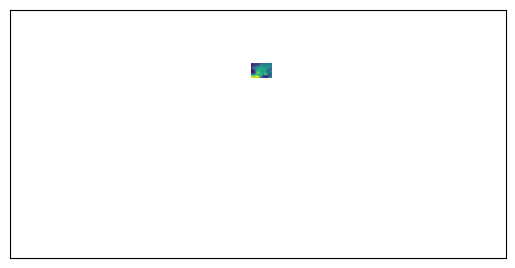

In [10]:
formatVpd = format_vpd(vpd, lon_grid, lat_grid, geo)

C:\Users\alexl\AppData\Local\Temp\ipykernel_13160\633882119.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


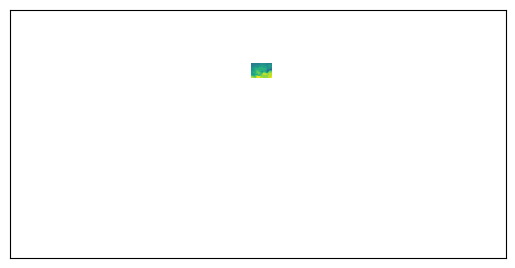

In [ ]:
tempMean = format_data(tempMeanRaw, lon_grid, lat_grid, geo, value_name="tempMean")
tempMax = format_data(tempMaxRaw, lon_grid, lat_grid, geo, value_name="tempMax")
tempMin = format_data(tempMinRaw, lon_grid, lat_grid, geo, value_name="tempMin")

C:\Users\alexl\AppData\Local\Temp\ipykernel_13160\2354906600.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections): #loop through contours


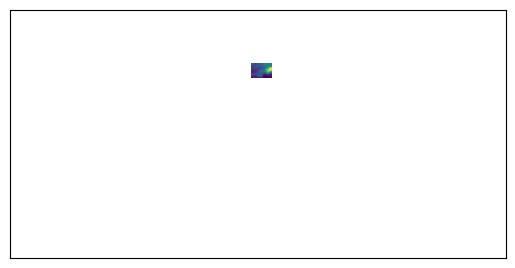

In [18]:
precipMean = format_data(precipMeanRaw, lon_grid, lat_grid, geo, value_name="precipMean", contourStep=5)

Text(0.5, 1.0, 'Precip 0.1°')

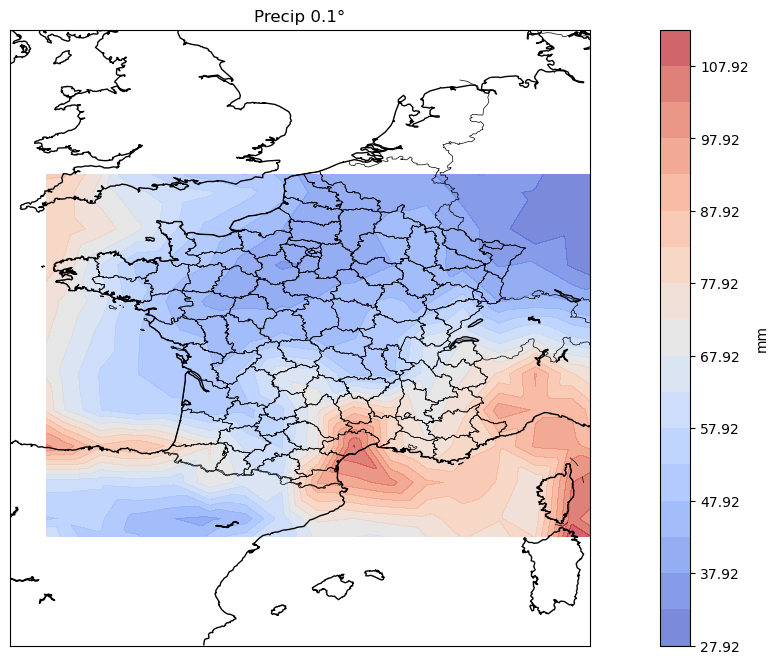

In [16]:
plt.figure(figsize=(18,8))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=38,  urcrnrlat=55, llcrnrlon=-6, urcrnrlon=10)
m.readshapefile("shp/geojsonfrance_corse_20", 'franceDep', drawbounds=True)
m.drawcoastlines()
m.drawcountries()
temperature_range = np.arange(np.min(precipMeanRaw[0] - 1), np.max(precipMeanRaw[0] + 1), 5)
contour = m.contourf(lon_grid, lat_grid, precipMeanRaw[0], levels=temperature_range, cmap='coolwarm', alpha=0.7)
cbar = plt.colorbar(contour, orientation='vertical', label="mm")
plt.title("Precip 0.1°")